In [1]:
!pip install langchain langchain_openai


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [2]:
!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [5]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")

In [9]:
# Función para hacer preguntas
def ask_question(query: str) -> str:
    input_data = {"country": query}
    final_state = graph.invoke(input_data, {"debug": True})  # Habilita el modo de depuración
    #final_message = final_state["final_answer"]
    return final_state

In [49]:
def save_narrativas_to_file(state: AnalysisState, filename="narrativas.json"):

    narrativas = {
        "ocupacion": state.narrativa_ocupacion,
        "informalidad": state.narrativa_informalidad
    }
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(narrativas, f, ensure_ascii=False, indent=2)

In [45]:
import re
import json
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
import pandas as pd
from typing import Dict, Any, Optional, List
from pydantic import BaseModel, Field
import duckdb

# Enhanced AnalysisState with reference country support
class AnalysisState(BaseModel):
    data: Dict[str, Any] = {}  # <-- holds both series and records per variable
    narrativa_ocupacion: str = ""
    narrativa_informalidad: str = ""
    errors: list = []
        
        
# Load dataset
archivo_parquet = "./ene-01-def-agregado.parquet"
df_empleo = pd.read_parquet("./ene-01-def-agregado.parquet")

queries = {
    "ocupados" : """
        SELECT datos.*
        FROM parquet_scan(?) AS datos
        WHERE variable = 'ocupados'
        ORDER BY año
        """,
    
    "ocupados_tpi" : """
        SELECT año, variable, valor
        FROM parquet_scan(?) AS datos
        WHERE variable IN ('ocupados', 'tpi')
        ORDER BY año
        """,
    
    "informalidad" : """
        SELECT
          año,
          variable,
          valor
        FROM parquet_scan(?) AS datos
        WHERE variable IN ('ocupados', 'formal', 'informal')  -- adjust as needed
        ORDER BY variable, año
        """,
}

def pivot_by_variable(df: pd.DataFrame) -> Dict[str, Dict[int, float]]:
    return {
        var: group.set_index("año")["valor"].to_dict()
        for var, group in df.groupby("variable")
    }

def pivot_by_year(df: pd.DataFrame) -> Dict[int, Dict[str, float]]:
    result = {}
    for _, row in df.iterrows():
        year = int(row["año"])
        var = row["variable"]
        val = float(row["valor"])
        if year not in result:
            result[year] = {}
        result[year][var] = val
    return result

def data_run_query(query) -> dict or str:
    # Conexión a DuckDB (en memoria)
    con = duckdb.connect()

    # Ejecutar consulta
    result = con.execute(query, [archivo_parquet]).fetchdf()

    if result.empty:
        return "No data found for variable 'ocupados'."
    
    series = result.set_index("año")["valor"].to_dict(),

    return {
        "by_variable": pivot_by_variable(result),
        "by_year": pivot_by_year(result)
    }


# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini")


def fetch_data(state: AnalysisState) -> AnalysisState:
    try:
        data_ocupados = data_run_query(queries["ocupados"])
        if isinstance(data_ocupados, str):  # Error message
            return state.copy(update={"errors": state.errors + [data_ocupados]})
        
        data_informalidad = data_run_query(queries["informalidad"])
        if isinstance(data_informalidad, str):  # Error message
            return state.copy(update={"errors": state.errors + [data_informalidad]})
        
        
        # Update the "data" dictionary with new entry
        updated_data = state.data.copy()
        updated_data["ocupados"] = data_ocupados
        updated_data["informalidad"] = data_informalidad

        return state.copy(update={"data": updated_data})



    except Exception as e:
        return state.copy(update={
            "errors": state.errors + [f"Data retrieval failed: {str(e)}"]
        })
    
prompt_base = """El objeto a continuación contiene datos de series temporales sobre indicadores laborales en Chile.
La sección by_variable permite analizar la evolución de cada variable en el tiempo.
La sección by_year permite comparar distintas variables dentro de un mismo año.
Los datos corresponden al trimestre diciembre-enero-febrero de cada año, por lo tanto:
Los datos hasta el año 2020 representan la situación prepandemia, ya que reflejan condiciones anteriores al primer caso de COVID-19 reportado en Chile (marzo de 2020).
Los datos de 2021 y 2022 corresponden al período de pandemia, y reflejan los efectos directos e indirectos de la crisis sanitaria.
A partir de 2023, los datos representan un período postpandemia, en el que debieran observarse tendencias de recuperación, ajuste o persistencia de efectos.
Redacta una narrativa concisa, clara y analítica que describa las principales tendencias y patrones observados. Considera los tres momentos mencionados para interpretar los cambios o continuidades en los datos."""


def build_narrativa_ocupacion(state: AnalysisState) -> AnalysisState:
    if state.errors:
        return state
    
    prompt_especifico = """El indicador a analizar en este caso es ocupados, que representa el total de personas que están empleadas en el país.
    Redacta una narrativa concisa, clara y analítica que describa las principales tendencias y patrones observados en el número de personas ocupadas 
    entre los distintos períodos descritos. Considera variaciones significativas, períodos de crecimiento o retroceso, y cualquier elemento que permita comprender la evolución del empleo en Chile durante este período.
    """
    prompt_total = f"""{prompt_base}\n\n{prompt_especifico}\n\nA partir del objeto entregado, elabora el análisis solicitado.\n\n
    Datos: {json.dumps(state.data['ocupados'], indent=2)}
    """
   
    state.narrativa_ocupacion = llm.invoke(prompt_total).content
    return state

def build_narrativa_informalidad(state: AnalysisState) -> AnalysisState:
    if state.errors:
        return state
    
    prompt_especifico = """El análisis se enfoca en la informalidad laboral en Chile.
    Se cuenta con datos del total de personas ocupadas, junto con la cantidad de personas en ocupaciones formales y en ocupaciones informales, correspondientes al trimestre diciembre-enero-febrero de cada año.
    Redacta una narrativa clara y analítica que describa la evolución de la informalidad tanto en términos absolutos (número de personas en ocupaciones informales) como en términos relativos (porcentaje de ocupados que están en ocupaciones informales).
    Identifica momentos de aumento o disminución de la informalidad, y relaciona estas variaciones con los tres períodos de análisis:
    Pre-pandemia (hasta el año 2020)
    Pandemia (años 2021 y 2022)
    Post-pandemia (a partir del año 2023)
    Si es posible, interpreta las razones o factores que podrían explicar las variaciones observadas.
    """
    prompt_total = f"""{prompt_base}\n\n{prompt_especifico}\n\nA partir del objeto entregado, elabora el análisis solicitado.\n\n
    Datos: {json.dumps(state.data['informalidad'], indent=2)}
    """
   
    state.narrativa_informalidad = llm.invoke(prompt_total).content
    return state




# === Updated Graph ===
builder = StateGraph(AnalysisState)

# Add all nodes
builder.add_node("fetch_data", fetch_data)
builder.add_node("build_narrativa_ocupacion", build_narrativa_ocupacion)
builder.add_node("build_narrativa_informalidad", build_narrativa_informalidad)

# Define execution flow
builder.add_edge(START, "fetch_data")
#builder.add_edge("fetch_data", END)

builder.add_edge("fetch_data", "build_narrativa_ocupacion")
builder.add_edge("build_narrativa_ocupacion", "build_narrativa_informalidad")
builder.add_edge("build_narrativa_informalidad", END)

# Compile graph
graph = builder.compile()

In [46]:
from IPython.display import Markdown, display

initial_state = AnalysisState().dict()
raw_state = graph.invoke(initial_state, {"debug": True})
final_state = AnalysisState(**raw_state)


#display(Markdown(answer))
print(final_state)

data={'ocupados': {'by_variable': {'ocupados': {2011: 7621029.946048457, 2012: 7874073.702067525, 2013: 7993296.994482528, 2014: 8202889.793072612, 2015: 8263091.077420165, 2016: 8417124.962288717, 2017: 8485699.612245208, 2018: 8787079.741272915, 2019: 8907637.494962297, 2020: 9063373.737067282, 2021: 8167623.309441002, 2022: 8768644.66719999, 2023: 9030161.591211021, 2024: 9309608.094348965, 2025: 9396873.67711522}}, 'by_year': {2011: {'ocupados': 7621029.946048457}, 2012: {'ocupados': 7874073.702067525}, 2013: {'ocupados': 7993296.994482528}, 2014: {'ocupados': 8202889.793072612}, 2015: {'ocupados': 8263091.077420165}, 2016: {'ocupados': 8417124.962288717}, 2017: {'ocupados': 8485699.612245208}, 2018: {'ocupados': 8787079.741272915}, 2019: {'ocupados': 8907637.494962297}, 2020: {'ocupados': 9063373.737067282}, 2021: {'ocupados': 8167623.309441002}, 2022: {'ocupados': 8768644.66719999}, 2023: {'ocupados': 9030161.591211021}, 2024: {'ocupados': 9309608.094348965}, 2025: {'ocupados': 9

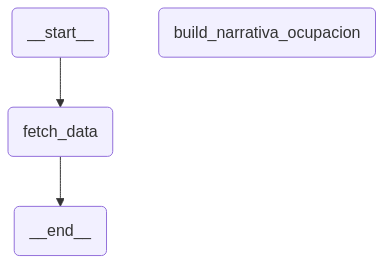

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [47]:
display(Markdown(final_state.narrativa_informalidad))


### Análisis de la Informalidad Laboral en Chile (2011-2025)

El análisis de la informalidad laboral en Chile desde 2011 hasta 2025 revela tendencias significativas relacionadas con las condiciones socioeconómicas del país, principalmente a través de tres periodos: prepandemia, pandemia y postpandemia.

#### 1. Prepandemia (Hasta 2020)

Durante el periodo prepandemia, la informalidad laboral en Chile fue relativamente estable. A partir de 2018, se registraron datos sobre la población informal, reflejando un crecimiento moderado. En 2018, había aproximadamente 2.54 millones de personas en ocupaciones informales, lo que representaba alrededor del 28.8% del total de ocupados (8.79 millones). Esta proporción se mantuvo en general estable en 2019 y aumentó ligeramente en 2020, con aproximadamente 2.63 millones de personas informales y un 29.0% de informalidad, lo que podría sugerir que el desempleo estaba comenzando a incrementarse debido a factores económicos previos a la pandemia, aunque la economía aún no mostraba un colapso significativo.

#### 2. Pandemia (2021-2022)

El impacto de la pandemia de COVID-19 en Chile se refleja de manera notoria en el mercado laboral y, específicamente, en la informalidad. En 2021, el número de personas en ocupaciones informales descendió drásticamente a aproximadamente 2.16 millones (26.5% del total de ocupados), una caída significativa en comparación con el año anterior. Esto se puede atribuir a la crisis económica provocada por la pandemia, que afectó desproporcionadamente a los sectores informales, donde muchos trabajadores perdieron su empleo de manera temporal o permanente.

A pesar de una leve recuperación en 2022, donde la informalidad aumentó nuevamente a cerca de 2.44 millones (27.8% del total de ocupados), el panorama general seguía siendo el de una economía en crisis, con la capacidad de los trabajadores informales para sostenerse disminuyendo.

#### 3. Postpandemia (A partir de 2023)

A partir de 2023, el escenario laboral en Chile parece estar en proceso de recuperación. El número de trabajadores informales aumenta ligeramente, alcanzando aproximadamente 2.47 millones, lo que corresponde a un 27.3% de la fuerza laboral total de 9.03 millones de ocupados. Esta ligero incremento, en comparación a 2022, sugiere que el mercado laboral se está ajustando postpandemia, aunque los niveles de informalidad aún no han recuperado los índices prepandemia, lo que podría señalar la persistente vulnerabilidad de los trabajadores en el sector informal.

#### Conclusiones

El análisis de la informalidad laboral en Chile muestra un patrón de estabilidad moderada durante la prepandemia, una caída dramática y abrupta durante la pandemia, y una lenta recuperación postpandemia. 

Las variaciones en el número y porcentaje de trabajadores informales pueden ser interpretadas a través de varios factores:

- **Crisis Económica:** La pandemia trajo consigo un deterioro generalizado del mercado laboral, afectando especialmente a aquellos en situaciones de vulnerabilidad, dejando a muchos sin acceso a trabajos formales.
- **Políticas Públicas:** La reacción del gobierno y las políticas de alivio económico también jugaron un papel crítico en la mitigación de estos efectos. La reducción de la informalidad en 2021 podría señalar el impacto inicial de tales políticas que, sin embargo, fueron insuficientes para devolver a los trabajadores informales a la formalidad.
- **Transiciones Estructurales:** A medida que el país comienza a recuperarse, es posible que siga existiendo una franja de informalidad que persista debido a cambios estructurales en la economía post-pandemia, donde algunos trabajadores, al perder sus empleos formales, puedan haber tomado opciones informales permanentes.

Con base en esta narrativa, es imperativo que las políticas laborales en Chile se centren en facilitar la transición de trabajadores informales a formales, promoviendo así una mayor estabilidad y protección laboral en el futuro.

In [50]:
# Guardar las narrativas generadas
save_narrativas_to_file(final_state)

print("✅ Narrativas guardadas en 'narrativas.json'")

✅ Narrativas guardadas en 'narrativas.json'
